Inspired by: https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2

In [1]:
import pandas as pd
import numpy as np
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from BERT_BASE import BertAGNewsDataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

from datasets import load_dataset

# Load AG News dataset
dataset = load_dataset("ag_news")

# Let's focus on the training data
full_train_dataset = dataset["train"]

# Split the dataset into training and validation using the built-in method
train_dataset = full_train_dataset.train_test_split(test_size=0.1, seed=42)

train_data = train_dataset['train']
val_data = train_dataset['test']

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [5]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#model = BERT().to(device)

# Create dataset objects for training and validation
train_dataset = BertAGNewsDataset(train_data, tokenizer, max_length=256)
val_dataset = BertAGNewsDataset(val_data, tokenizer, max_length=256)

# DataLoader for creating batches for both training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
class BERT(nn.Module):
    def __init__(self, num_classes=4):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")
        self.out = nn.Linear(768, num_classes)

    def forward(self,ids,mask,token_type_ids):
        _ ,o2= self.bert_model(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )
        out= (self.out(o2))

        return out

model=BERT()

loss_fn = nn.CrossEntropyLoss()

#Initialize Optimizer
optimizer= optim.Adam(model.parameters(),lr= 0.001)

In [7]:
for param in model.bert_model.parameters():
    param.requires_grad = False

In [8]:
def finetune(epochs, train_dataloader, val_dataloader, model, loss_fn, optimizer):
    model.train()

    # For storing metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        train_losses, train_accuracies = [], []

        # Training loop
        for dl in tqdm(train_dataloader, leave=False, desc=f'Training Epoch {epoch + 1}/{epochs}'):
            ids = dl['ids'].to(device)
            token_type_ids = dl['token_type_ids'].to(device)
            mask = dl['mask'].to(device)
            labels = dl['target'].unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(outputs, labels.view(-1).long())
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            preds = outputs.argmax(dim=1).int()
            accuracy = (preds.view(-1) == labels.view(-1)).float().mean()
            train_losses.append(loss.item())
            train_accuracies.append(accuracy.item())

        # Validation loop
        val_losses, val_accuracies = [], []
        model.eval()
        with torch.no_grad():
            for dl in tqdm(val_dataloader, leave=False, desc=f'Validating Epoch {epoch + 1}/{epochs}'):
                ids = dl['ids'].to(device)
                token_type_ids = dl['token_type_ids'].to(device)
                mask = dl['mask'].to(device)
                labels = dl['target'].unsqueeze(1).to(device)

                outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
                loss = loss_fn(outputs, labels.view(-1).long())

                # Calculate accuracy
                preds = outputs.argmax(dim=1).int()
                accuracy = (preds.view(-1) == labels.view(-1)).float().mean()
                val_losses.append(loss.item())
                val_accuracies.append(accuracy.item())

        # Logging the metrics
        avg_train_loss = np.mean(train_losses)
        avg_train_acc = np.mean(train_accuracies)
        avg_val_loss = np.mean(val_losses)
        avg_val_acc = np.mean(val_accuracies)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    return model, history

In [9]:
model = model.to(device)

model, history = finetune(10, train_loader, val_loader, model, loss_fn, optimizer)

KeyboardInterrupt: 

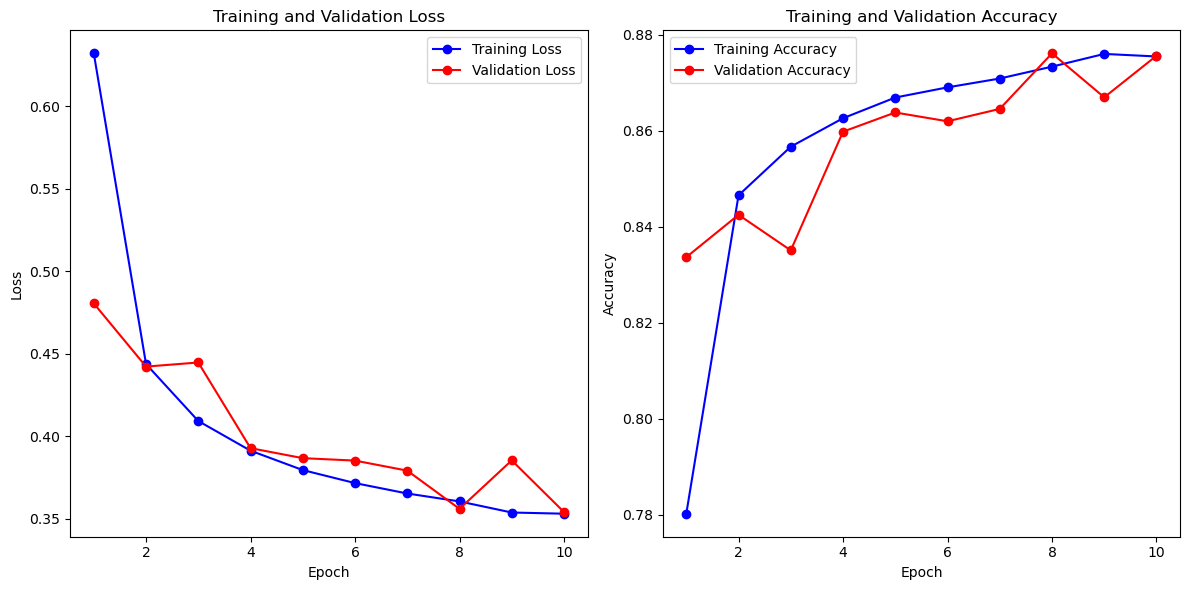

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

In [ ]:
# Save the entire model
torch.save(model, 'BERT_Fast.pth')

In [ ]:
model = torch.load('BERT_Fast.pth')
model.eval()  # Set the model to evaluation mode

BERT(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
print(dataset['test'])

Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

# Assuming dataset['test'] is already a suitable Dataset object
test_dataset = BertAGNewsDataset(dataset['test'], tokenizer, max_length=256)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for dl in tqdm(dataloader, desc='Testing'):
            ids = dl['ids'].to(device)
            token_type_ids = dl['token_type_ids'].to(device)
            mask = dl['mask'].to(device)
            labels = dl['target'].unsqueeze(1).to(device)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(outputs, labels.view(-1).long())
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).int()
            accuracy = (preds.view(-1) == labels.view(-1)).float().mean()
            total_accuracy += accuracy.item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    return avg_loss, avg_accuracy

# Load the model if not already loaded
model = torch.load('BERT_Fast.pth')
model = model.to(device)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Testing: 100%|██████████| 238/238 [01:18<00:00,  3.05it/s]

Test Loss: 0.3599, Test Accuracy: 0.8750
